In [35]:
%matplotlib inline

import numpy as np
from tqdm import tqdm

In [89]:
class Venus:
    
    def __init__(
        self,
        inj_limits=[175, 185],
        mid_limits=[145, 155],
        ext_limits=[135, 145],
        beam_range=[50, 100],
        jitter=0
    ):
        """The limits on the magnetic solenoids currents and the beam range (ouput).
        A random jitter can be added also (fraction of 1.)."""
        self.inj_limits = inj_limits
        self.mid_limits = mid_limits
        self.ext_limits = ext_limits
        self.beam_range = beam_range
        self.currents = np.zeros(3)
        self.jitter = jitter
        self.rng = np.random.default_rng(42)

    def set_mag_currents(self, inj, mid, ext):
        """Set the magnetic currents on the coils."""
        for v, lim in zip([inj, mid, ext], [self.inj_limits, self.mid_limits, self.ext_limits]):
            if v < lim[0] or v > lim[1]:
                raise ValueError("Setting outside limits")
        self.currents = np.array([inj, mid, ext])

    def _rescale_inputs(self, inputs):
        """input to himmelblau4 must be in [-6, 6]."""
        return (
            (c - l[0]) * 12.0 / (l[1] - l[0]) - 6.0
            for c, l in zip(inputs, [self.inj_limits, self.mid_limits, self.ext_limits])
        )
    
    def get_noise_level(self):
        # return std of the noise
        noise = self.jitter*(self.beam_range[1] - self.beam_range[0])
        return noise
    
    def _rescale_output(self, output):
        """himmelblau4 returns values betwen 0 and 4899 for w, x, y, z in [-6, 6]."""
        return (
            (1. - (output / 4899) + self.rng.normal(0.0, self.jitter)) *
            (self.beam_range[1] - self.beam_range[0]) + self.beam_range[0]
        )

    def get_beam_current(self):
        """Read the current value of the beam current"""
        return self._rescale_output(self._himmelblau4(*self._rescale_inputs(self.currents)))

    @staticmethod
    def _himmelblau4(w, x, y):
        """A funky 4 dimensional parameter space with a bunch of local minima."""
        return (
            (w**2 + x + y - 11)**2 +
            (w + x**2 + y - 7)**2 +
            (w + x + y**2 - 5)**2 + 0.001 * x
        )

create a venus object, defaults might be refined by values from Damon. For simpler algorithm the jitter can be set to 0 initially but it should work with a value larger than that in the end.

In [90]:
venus = Venus(jitter=0.)

set the currents and read the beam value

In [91]:
venus.set_mag_currents(185, 155, 145)
bc = venus.get_beam_current()
print(bc)

49.99993876301285


if currents are outside the range a `ValueError` is raised and can be captured.

In [92]:
venus.set_mag_currents(50, 200, 200)

ValueError: Setting outside limits

In [93]:
venus._himmelblau4(6, 6, 6)

4899.006

# Bayesian Optimization

In [94]:
import numpy as np
import matplotlib.pyplot as plt

from bayes_opt import BayesianOptimization, UtilityFunction
import warnings
warnings.filterwarnings("ignore")

# Define the black box function to optimize.
def black_box_function(A, B, C):
    # C: SVC hyper parameter to optimize for.
    venus.set_mag_currents(A, B, C)
    v = venus.get_beam_current()
    return v

# Set range of C to optimize for.
# bayes_opt requires this to be a dictionary.
pbounds = {"A": [175, 185], "B": [145, 155], "C": [135, 145]}
# Create a BayesianOptimization optimizer,
# and optimize the given black_box_function.
noise = venus.get_noise_level()
print(noise)
optimizer = BayesianOptimization(f = black_box_function,
                                 pbounds = pbounds, verbose = 2,
                                 random_state = 38)
optimizer.maximize(init_points = 5, n_iter = 40, kappa=2.3, alpha=noise**2)
print("Best result: {}; f(x) = {}.".format(optimizer.max["params"], optimizer.max["target"]))

0.0
|   iter    |  target   |     A     |     B     |     C     |
-------------------------------------------------------------
|  1        |  90.43    |  178.8    |  153.6    |  144.4    |
|  2        |  99.94    |  182.0    |  151.3    |  141.1    |
|  3        |  98.53    |  177.0    |  148.9    |  137.6    |
|  4        |  96.73    |  175.7    |  147.8    |  139.4    |
|  5        |  97.96    |  179.8    |  153.7    |  140.3    |
|  6        |  98.86    |  181.0    |  151.1    |  139.4    |
|  7        |  95.28    |  184.4    |  152.6    |  139.7    |
|  8        |  99.14    |  181.0    |  150.2    |  141.2    |
|  9        |  98.97    |  183.5    |  149.1    |  142.2    |
|  10       |  95.39    |  177.7    |  152.2    |  135.9    |
|  11       |  99.61    |  182.5    |  148.1    |  139.5    |
|  12       |  96.56    |  180.3    |  146.8    |  137.5    |
|  13       |  94.87    |  184.4    |  146.4    |  140.5    |
|  14       |  99.84    |  182.7    |  149.8    |  140.3    |
|  1

In [72]:
# try a certain times and see how many converges
def trial(N, n_iter = 15, init_points = 5, kappa = 3, verbose = 0, rand_adder = 0):
    # higher kappa prefers exploration
    # initial points are randomly chosen within bounds
    # rand_adder is to make sure we probe some different randstates in each trial
    rand_adder = int(rand_adder)
    results = []
    noise = venus.get_noise_level()
    for i in tqdm(range(N)):
        optimizer = BayesianOptimization(f = black_box_function,
                                         pbounds = pbounds, verbose = 0,
                                         random_state = i+rand_adder)
        optimizer.maximize(init_points = init_points, n_iter = n_iter, kappa=kappa, alpha=noise)
        if verbose>1:
            print("Best result: {}; f(x) = {}.".format(optimizer.max["params"], optimizer.max["target"]))
        results.append(optimizer.max["target"])
    
    plt.title("n_iter = {}, init_points = {}, kappa = {}".format(n_iter, init_points, kappa))
    plt.hist(results)
    plt.show()
    if verbose > 0:
        print(list(reversed(sorted(results))))
    

## Simple Trial

100%|███████████████████████████████████████████| 20/20 [00:02<00:00,  7.26it/s]


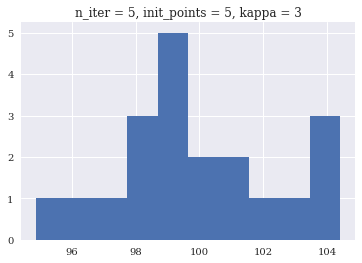

In [55]:
trial(20, n_iter = 5, init_points = 5, kappa = 3, verbose = 0, rand_adder = 1e2)

## Making sure our method is better than random

100%|███████████████████████████████████████████| 20/20 [00:09<00:00,  2.16it/s]


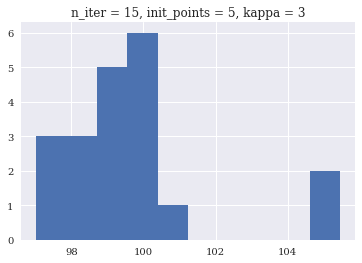

[105.45860239542026, 104.99938158323536, 101.12039506165013, 100.34431655181133, 100.3008318567152, 100.14664158351715, 100.09170010116173, 100.01552861983808, 99.62226854884051, 99.29356421053619, 99.25201683847403, 99.04579006789132, 98.99747454259096, 98.85846420089052, 98.59458520577599, 98.0535721048324, 97.99665920939044, 97.80309553239684, 97.74319522876087, 97.01084747974284]


In [56]:
trial(20, n_iter = 15, init_points = 5, kappa = 3, verbose = 1, rand_adder = 2e2)

100%|███████████████████████████████████████████| 20/20 [00:02<00:00,  7.76it/s]


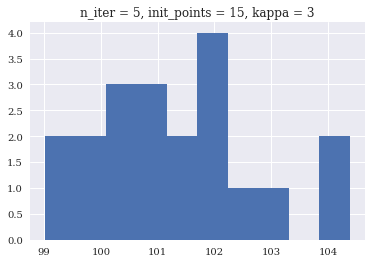

[104.37729520897736, 104.25400471089094, 103.25278312144948, 102.57689575339673, 102.06381408560108, 102.0328937441221, 101.82359941242304, 101.78574617979186, 101.65945368440251, 101.16788909470822, 101.15612425270233, 100.84079947110325, 100.66053228861149, 100.60222128142783, 100.57493446961941, 100.45841930774756, 99.90528027483265, 99.83993658023951, 99.39260950312645, 99.02386263087098]


In [57]:
# we see that more iteration is better than more initial points, meaning our sampling is more efficient than random sample
trial(20, n_iter = 5, init_points = 15, kappa = 3, verbose = 1, rand_adder = 3e2)

## Trying out kappa

100%|███████████████████████████████████████████| 30/30 [01:12<00:00,  2.41s/it]


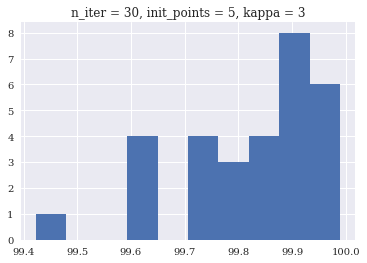

[99.9896012532723, 99.98847556935769, 99.97633356826746, 99.97001395125984, 99.94790393563196, 99.94148630086559, 99.92317136717276, 99.91428246896828, 99.90464032898475, 99.89770648981448, 99.89608510764927, 99.88680112350411, 99.88663449881209, 99.88372783057369, 99.86302752618872, 99.85698484892177, 99.85458132892353, 99.84565447510573, 99.80624210530794, 99.79794856524416, 99.7881054648525, 99.7478083442753, 99.73464553709096, 99.7289757006588, 99.71201293772367, 99.62733021792755, 99.6159342909774, 99.61333734266914, 99.59862623238189, 99.42269268147444]


In [38]:
trial(30, n_iter = 30, init_points = 5, kappa = 3, verbose = 1, rand_adder = 5e2)

100%|███████████████████████████████████████████| 30/30 [01:16<00:00,  2.56s/it]


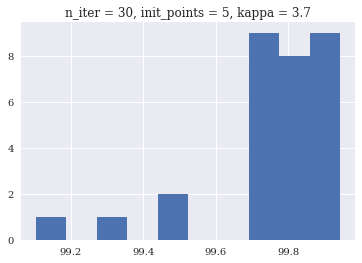

[99.9440806968612, 99.93415292603405, 99.92563341256914, 99.9170920822363, 99.89290512323879, 99.89229629503043, 99.89023030162332, 99.86961217254424, 99.86116527045309, 99.85802912167102, 99.85692488504438, 99.85134043318678, 99.81697720471885, 99.80215312267578, 99.80211940436965, 99.79504477378475, 99.7871645915383, 99.7723427358491, 99.76366173574179, 99.75901161017849, 99.75727933324521, 99.75574420862179, 99.73296480801542, 99.72743586371831, 99.70538905992692, 99.70347610980538, 99.52300426218625, 99.48721672745968, 99.32685444996844, 99.10299493816234]


In [39]:
trial(30, n_iter = 30, init_points = 5, kappa = 3.7, verbose = 1, rand_adder = 7e2)

100%|███████████████████████████████████████████| 30/30 [01:21<00:00,  2.71s/it]


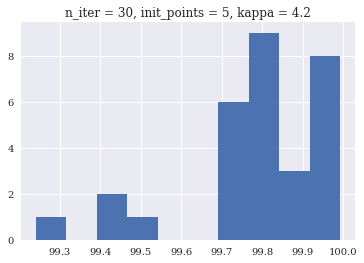

[99.99282846986006, 99.97597157526137, 99.97381887913336, 99.95848251715611, 99.94669809402147, 99.94349666436293, 99.9323005851941, 99.91785678733544, 99.91049550864764, 99.90759234051518, 99.90600535622806, 99.82615429735219, 99.82523947059997, 99.8173288808542, 99.80632711068418, 99.78293490685765, 99.78235714668465, 99.78221976778241, 99.76976637516661, 99.76716684035767, 99.75288044370397, 99.74672888477299, 99.73483897857535, 99.73336252745008, 99.72601180202874, 99.7061224741984, 99.5202214527682, 99.46140461983055, 99.44285337592964, 99.24061662979827]


In [40]:
trial(30, n_iter = 30, init_points = 5, kappa = 4.2, verbose = 1, rand_adder = 8e2)

100%|███████████████████████████████████████████| 30/30 [01:27<00:00,  2.92s/it]


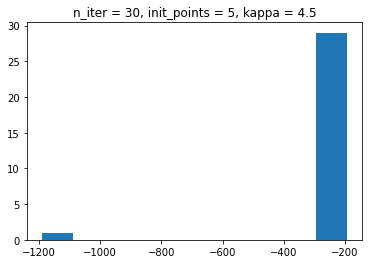

In [118]:
trial(30, n_iter = 30, init_points = 5, kappa = 4.5, verbose = 1, rand_adder = 9e2)

## Increase n_iter

100%|███████████████████████████████████████████| 30/30 [04:09<00:00,  8.30s/it]


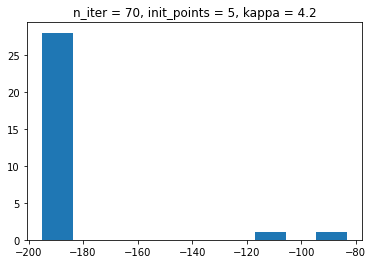

[-83.41717482507394, -108.00906940923039, -195.0, -195.0, -195.0, -195.0, -195.0, -195.0, -195.0, -195.0, -195.0, -195.0, -195.0, -195.0, -195.0, -195.0, -195.0, -195.0, -195.0, -195.0, -195.0, -195.0, -195.0, -195.0, -195.0, -195.0, -195.0, -195.0, -195.0, -195.0]


In [130]:
trial(30, n_iter = 70, init_points = 5, kappa = 4.2, verbose = 1, rand_adder = 1e3)

100%|███████████████████████████████████████████| 30/30 [04:24<00:00,  8.83s/it]


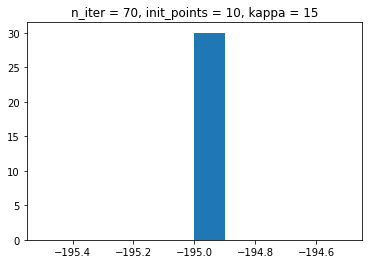

[-195.0, -195.0, -195.0, -195.0, -195.0, -195.0, -195.0, -195.0, -195.0, -195.0, -195.0, -195.0, -195.0, -195.0, -195.0, -195.0, -195.0, -195.0, -195.0, -195.0, -195.0, -195.0, -195.0, -195.0, -195.0, -195.0, -195.0, -195.0, -195.0, -195.0]


In [142]:
trial(30, n_iter = 70, init_points = 10, kappa = 15, verbose = 1, rand_adder = 1.1e3)

100%|███████████████████████████████████████████| 30/30 [04:37<00:00,  9.25s/it]


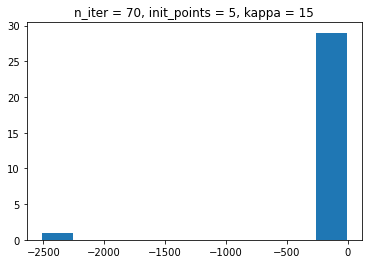

[-9.460997841425904, -194.99999999999991, -195.0, -195.0, -195.0, -195.0, -195.0, -195.0, -195.0, -195.0, -195.0, -195.0, -195.0, -195.0, -195.0, -195.0, -195.0, -195.0, -195.0, -195.0, -195.0, -195.0, -195.0, -195.0, -195.0, -195.0, -195.0, -195.0, -195.0, -2510.300282621165]


In [137]:
trial(30, n_iter = 70, init_points = 5, kappa = 15, verbose = 1, rand_adder = 1.2e3)

In [ ]:
# TODO: guide optimization to known good points

In [65]:
# unused. Potentially for future tests
# from deap import benchmarks

# def ackley_arg0(sol):
#     return benchmarks.ackley(sol)[0]

In [66]:
# ackley_arg0((0,0,0))

In [ ]:
# Global min: (182.5, 151.7, 140.0) value
# TODO: use get current function
# scikit optimization
# skopt2